In [1]:
import random

import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import trange

import torch
from torch import nn

source = "../source"
sys.path.append(source)


from data import seq_data
from preprocessing import OneHot
from compilation import Compiler, ScalarTracker, ActivationTracker
from data_analysis.automata import (
    to_automaton_history,
    reduce_automaton,
    to_automaton,
    has_all_transitions,
)
from visualization.animation import SliderAnimation
from visualization.activations import ActivationsAnimation
from visualization.automata import AutomatonAnimation, display_automata
from visualization.epochs import EpochAnimation

from model import Model
import publication

is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

torch.manual_seed(0)

random.seed(0)

GPU is available


In [2]:
save = False

In [3]:
## Load settings
settings = "rich"

(nonlinearity, gain, lr, P, L, n_epochs, max_seq_len) = (
    pd.read_csv("model settings/rnn.txt", sep=" ", header=0).loc[settings].to_numpy()
)
P, L, n_epochs, max_seq_len = int(P), int(L), int(n_epochs), int(max_seq_len)

In [4]:
gain = 0.0000000001
max_seq_len = 12
lr = 0.001
n_epochs = 1000
P = 100

In [5]:
gain = 0.1
max_seq_len = 14
lr = 0.0001
n_epochs = 2000
P = 100

In [7]:
# gain = 0.000001
# max_seq_len = 12
# lr = 0.001
# n_epochs = 500
# P = 200

In [8]:
# gain = 1.0
# max_seq_len = 14
# lr = 0.001
# n_epochs = 500
# P = 300

In [9]:
## Generate data

# Define problem and data encoding
symbols = [0, 1]
encoding = OneHot(symbols)
# problem = lambda seq: np.sum(seq) % 2  # XOR problem
# problem = lambda seq: (np.sum(seq) % 3) % 2
problem = lambda seq: int(np.sum(seq) % 5 == 0)

# Define sequence lengths for training and validation datasets
train_seq_lengths = list(range(1, max_seq_len + 1))
# analysis_seq_lengths = train_seq_lengths
analysis_seq_lengths = list(range(1, 10 + 1))
val_seq_length = 50
val_datapoints = 32

# Generate datasets
training_datasets = [
    seq_data(device, problem, encoding, seq_len=length) for length in train_seq_lengths
]
validation_datasets = [
    seq_data(
        device, problem, encoding, n_datapoints=val_datapoints, seq_len=val_seq_length
    )
]
analysis_data = [
    seq_data(device, problem, encoding, seq_len=length)
    for length in analysis_seq_lengths
]
tracked_datasets = validation_datasets + analysis_data + training_datasets

In [10]:
## Instantiate model
model = Model(
    encoding=encoding,
    input_size=len(symbols),
    output_size=len(symbols),
    hidden_dim=P,
    n_layers=L,
    device=device,
    nonlinearity=nonlinearity,
    gain=gain,
)

In [11]:
## Setup compiler
criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=True, weight_decay=0.00)
compiler = Compiler(model, criterion, optimizer)
initial_hidden = model.init_hidden(batch_size=1)[-1]
hidden_function = lambda inputs: model(inputs)[1][-1]
output_function = lambda inputs: model(inputs)[0]
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    "hidden": ActivationTracker(
        encoding,
        hidden_function,
        analysis_data,
        initial=lambda: initial_hidden,
    ),
    "output": ActivationTracker(encoding, output_function, analysis_data),
}

In [11]:
## Training run
compiler.training_run(
    training_datasets,
    n_epochs=n_epochs,
    batch_size=128,
)

Training:  58%|█████▊    | 1153/2000 [38:37<35:00,  2.48s/steps, train_loss=0.00047, val_loss=0.17559] 

In [12]:
########### learn algorithm with uneven data distribution over states, so merging happens in steps

In [13]:
## compute percentage merged as function of seq len

In [14]:
## ON TRANSFORMER TEST BEHAVIOUR ON ARBITRAY LONG RANGE SEQUENCE

In [15]:
## Visualize automaton dynamics

# Filter and process data for visualization
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()
query = "(Dataset <= 12)"
data_hid = data_hid.query(query).copy()
data_output = data_output.query(query).copy()

epochs = list(set(data_hid.index.get_level_values("Epoch")))
epochs.sort()

std = float(np.linalg.norm(data_hid.std()))
n_points = len(data_hid.query("Epoch == 0"))

automaton_history = to_automaton_history(
    data_hid, data_output, merge_distance=0.1 * std
)
loss = compiler.trackers["loss"].get_trace()
val_loss = loss.query("Dataset==0")[0].to_numpy()
train_loss = loss.query("Dataset>0").groupby("Epoch").mean()
n_states = np.array([len(automaton.states) for automaton in automaton_history])
is_finite = np.array([automaton.is_finite() for automaton in automaton_history])

Computing automata: 100%|██████████| 1000/1000 [06:34<00:00,  2.54it/s]


In [16]:
# n_exit = np.array(
#     [
#         sum(
#             not has_all_transitions(state, automaton.transition_function)
#             for state in automaton.states
#         )
#         for automaton in automaton_history
#     ]
# )

In [17]:
## plot number of reduced states

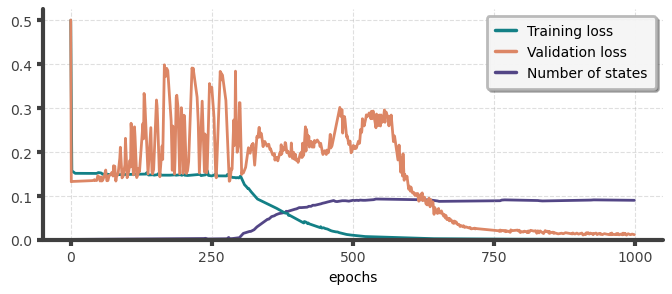

In [18]:
n_datapoints = sum(len(dataset) for dataset in analysis_data)

publication.set_color_mixed()
plt.figure(figsize=(8, 3))
plt.plot(np.array(train_loss[0]), label="Training loss")
plt.plot(val_loss, label="Validation loss")
# plt.plot(n_states / n_datapoints, label="Number of states", zorder=0, color="0.5")
plt.plot(n_states / n_datapoints, label="Number of states", zorder=0)
# plt.plot(n_exit / n_datapoints)
plt.xlabel("epochs")
plt.ylim(0)
plt.legend()
if save:
    publication.plt_show(save_path=f"plots/automaton_dynamics/{settings}_loss")
else:
    publication.plt_show()

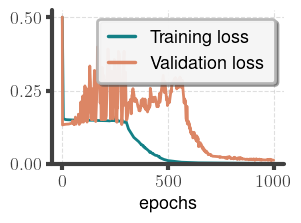

In [19]:
n_datapoints = sum(len(dataset) for dataset in training_datasets)

publication.set_color_mixed()
plt.figure(figsize=(3, 2))
plt.plot(train_loss, label="Training loss")
plt.plot(val_loss, label="Validation loss")
plt.xlabel("epochs")
plt.ylim(0)
plt.legend()
if save:
    publication.plt_show(save_path=f"plots/automaton_dynamics/{settings}_loss_small")
else:
    publication.plt_show()

100%|██████████| 500/500 [00:01<00:00, 431.76it/s]


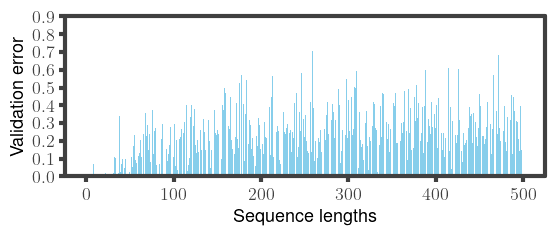

In [20]:
## Check for large sequence length generalization

# Evaluate model generalization for sequences of varying lengths
N = 500
val_data = []
for n in trange(1, N + 1):
    val_data.append(seq_data(device, problem, encoding, n_datapoints=10, seq_len=n))
val_err = compiler.validation(val_data).to_numpy()[:, 0]

# Visualize validation error for varying sequence lengths
publication.set_color_mixed()
fig = plt.figure(figsize=(6, 2))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.bar(np.arange(1, N + 1), val_err, color="skyblue")
ax.set_xlabel("Sequence lengths")
ax.set_ylabel("Validation error")
# ax.set_title("Model Generalization Across Sequence Lengths")
ax.set_yticks(np.arange(0, 1, 0.1))
if save:
    publication.pub_show(save_path=f"plots/automaton_dynamics/{settings}_validation")
else:
    publication.pub_show()

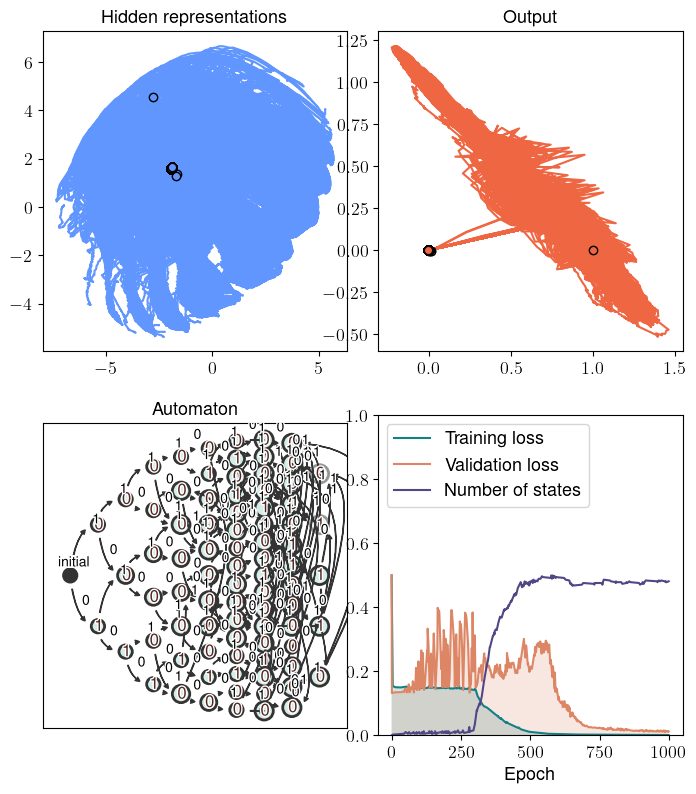

interactive(children=(SelectionSlider(description='Epoch:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,…

In [21]:
# Create animation
plot_labels = False
publication.set_color_mixed()
animation = SliderAnimation(
    {
        "Hidden representations": ActivationsAnimation(
            data_hid,
            transform="PCA",
            colors=[5] * n_points,
            plot_labels=plot_labels,
        ),
        "Output": ActivationsAnimation(
            data_output,
            transform="none",
            fixed_points=encoding.encoding,
            colors=[6] * n_points,
            plot_labels=plot_labels,
        ),
        "Automaton": AutomatonAnimation(automaton_history, reduce_automata=True),
        "Loss": EpochAnimation(
            graphs={
                "Training loss": train_loss,
                "Validation loss": val_loss,
            },
            unitless_graphs={
                "Number of states": n_states,
            },
            y_bounds=(0, 1),
        ),
    },
    parameters=epochs,
    parameter_name="Epoch",
    fig_size=4,
)

# Optionally export the animation
if save:
    animation.to_gif(f"plots/automaton_dynamics_{settings}")

In [22]:
# animation.to_gif(f"plots/automaton_dynamics_reduced_{settings}")

Computing automata: 100%|██████████| 1/1 [00:18<00:00, 18.95s/it]


KeyError: State(000000, 00111110000000, 01011110000000, 01101001100000, 01101010100000, 01101011000000, 01101100100000, 01101101000000, 01101110000000, 01110001100000, 01110010100000, 01110011000000, 01110100100000, 01110101000000, 01110110000000, 01111000100000, 01111001000000, 01111010000000, 01111100000000, 10011101000000, 10011110000000, 10100011100000, 10100111000000, 10101001100000, 10101010100000, 10101011000000, 10101100100000, 10101101000000, 10101110000000, 10110001100000, 10110010100000, 10110011000000, 10110100100000, 10110101000000, 10110110000000, 10111000100000, 10111001000000, 10111010000000, 10111100000000, 11000011100000, 11000101100000, 11000110100000, 11000111000000, 11001001100000, 11001010100000, 11001011000000, 11001100100000, 11001101000000, 11001110000000, 11010001100000, 11010010100000, 11010011000000, 11010100100000, 11010101000000, 11010110000000, 11011000100000, 11011001000000, 11011010000000, 11011100000000, 11100001100000, 11100010100000, 11100011000000, 11100100100000, 11100101000000, 11100110000000, 11101000100000, 11101001000000, 11101010000000, 11101100000000, 11110000100000, 11110001000000, 11110010000000, 11110100000000)

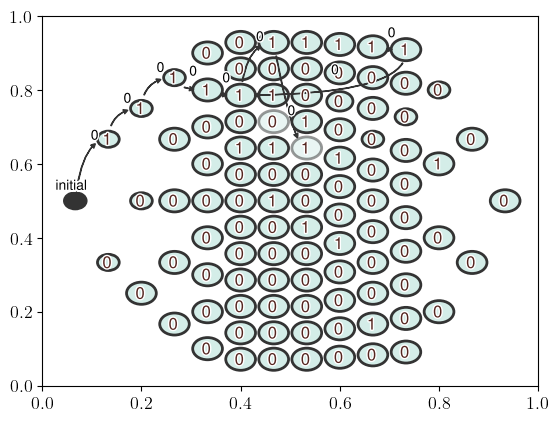

In [24]:
automaton = to_automaton(
    hidden_function,
    output_function,
    initial_hidden,
    training_datasets,
    encoding,
    merge_distance_frac=0.3,
)
display_automata(reduce_automaton(automaton))
if save:
    publication.pub_show(
        save_path=f"plots/automaton_dynamics/{settings}_automaton_reduced"
    )
else:
    publication.pub_show()

KeyError: State(0000011, 0000101, 0000111, 0001001, 0001011, 0001111, 0010011, 0010111, 0011011, 0100011, 0100111, 0101011, 0110011, 1000011, 1000111, 1001001, 1001011, 1010011, 1011011, 1100011, 1100111, 1101011, 1110011)

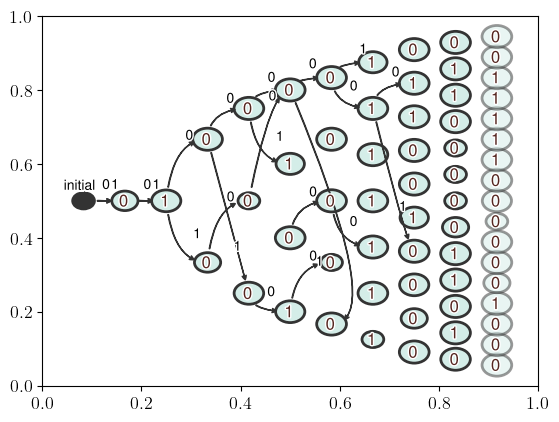

In [23]:
match settings:
    case "rich":
        epoch_choices = [0, 1000, 1999]
    case "intermediate":
        epoch_choices = [0, 350, 660, 1999]
    case "lazy":
        epoch_choices = [0, 1999]
    case "low_data":
        epoch_choices = [0, 600,1999]

for epoch in epoch_choices:
    automaton = automaton_history[epoch]
    display_automata(automaton)
    if save:
        publication.pub_show(
            save_path=f"plots/automaton_dynamics/{settings}_automaton_epoch_{epoch}"
        )
    else:
        publication.pub_show()

In [22]:
stop

NameError: name 'stop' is not defined

  0%|          | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_25968/2576878443.py:23: RuntimeWarning: divide by zero encountered in divide
  fraction = 1 / dist
100%|██████████| 2000/2000 [03:03<00:00, 10.88it/s]


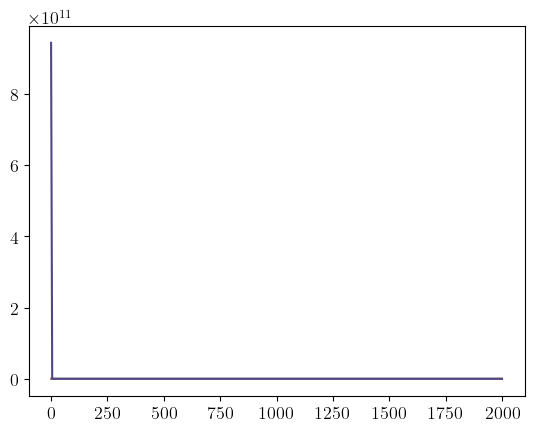

In [ ]:
import scipy
from sklearn.cluster import AgglomerativeClustering
from tqdm import tqdm

import numpy as np

data_hid = compiler.trackers["hidden"].get_trace()
counts = []
# for n, h in tqdm(data_hid.groupby("Epoch")):
#     H = h.to_numpy()
#     if n == 0:
#         dist = scipy.spatial.distance_matrix(H, H)
#         threshold = 0.01 * np.max(dist)
#     clustering = AgglomerativeClustering(
#         n_clusters=None, distance_threshold=threshold
#     ).fit(H)
#     count = max(clustering.labels_)
#     counts.append(count)


def count_states(H):
    dist = scipy.spatial.distance_matrix(H, H)
    fraction = 1 / dist
    fraction = np.sum(np.nan_to_num(fraction, nan=0.0, posinf=0.0, neginf=0.0))
    return fraction


for n, h in tqdm(data_hid.groupby("Epoch")):
    H = h.to_numpy()
    counts.append(count_states(H))

loss = compiler.trackers["loss"].get_trace()
val_loss = loss.query("Dataset==0")[0].to_numpy()
train_loss = loss.query("Dataset>0").groupby("Epoch").mean()
# counts = scipy.ndimage.gaussian_filter(counts, 5)
plt.plot(train_loss)
plt.plot(val_loss)
plt.plot(np.array(counts) / (H.shape[0]))
# plt.ylim(0, 1)
plt.show()